In [1]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 6

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 1. Data Wrangling

In [3]:
#Read negative and positive training reviews into train dataframe
#Add a column to label positive reviews as 1 and negative reviews as 0
import glob
train_pos_filenames = glob.glob("./aclImdb/train/pos/*.txt")
train_neg_filenames = glob.glob("./aclImdb/train/neg/*.txt")

pos_reviews = []
neg_reviews = []
rating = []

#User-defined function that extracts the rating from the file name and reads the reviews
#Returns a dataframe with review, rating and label columns
def read_file(filenames,label):
    reviews = []
    rating = []
    for file in filenames:
        if file[-6] == '1':
            rating.append(10)
        else:
            rating.append(file[-5])
        with open(file) as f:
            text = f.read()
            reviews.append(text)
    df = pd.DataFrame(reviews, columns=['review'])
    df['rating'] = list(map(int, rating))
    df['label'] = label
    return df

imdb_pos_train = read_file(train_pos_filenames, 1)
imdb_neg_train = read_file(train_neg_filenames, 0)
#Combine both dataframes to form one training dataframe
imdb_train = pd.concat([imdb_pos_train, imdb_neg_train], ignore_index=True )

#Read negative and positive testing reviews into test dataframe
#Add a column to label positive reviews as 1 and negative reviews as 0
test_pos_filenames = glob.glob("./aclImdb/test/pos/*.txt")
test_neg_filenames = glob.glob("./aclImdb/test/neg/*.txt")

imdb_pos_test = read_file(test_pos_filenames, 1)
imdb_neg_test = read_file(test_neg_filenames, 0)
#Combine both dataframes to form one training dataframe
imdb_test = pd.concat([imdb_pos_test, imdb_neg_test], ignore_index=True )

In [4]:
imdb_train.head()

,review,rating,label
0,For a movie that gets no respect there sure ar...,9,1
1,Bizarre horror movie filled with famous faces ...,8,1
2,"A solid, if unremarkable film. Matthau, as Ein...",7,1
3,It's a strange feeling to sit alone in a theat...,8,1
4,"You probably all already know this by now, but...",10,1


In [5]:
imdb_test.head()

,review,rating,label
0,"Based on an actual story, John Boorman shows t...",9,1
1,This is a gem. As a Film Four production - the...,9,1
2,"I really like this show. It has drama, romance...",9,1
3,This is the best 3-D experience Disney has at ...,10,1
4,"Of the Korean movies I've seen, only three had...",10,1


In [6]:
#Shuffle the rows of train and test 
imdb_train = imdb_train.sample(frac=1).reset_index(drop=True)
imdb_test = imdb_test.sample(frac=1).reset_index(drop=True)

## 1.1 Text Preprocessing

In [7]:
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

eng_stopwords = stopwords.words('english') 
wl = WordNetLemmatizer()
s = PorterStemmer()

In [8]:
#Remove unwanted characters and normalize the text
def normalize_text(text):
    norm_text = text.lower()
    # Replace breaks with spaces
    norm_text = norm_text.replace('<br />', ' ')
    #Pad punctuation with spaces on both sides
    norm_text = re.sub(r"([\.\"\(\)\-!\?;:',0-9_~])", "" , norm_text)
    return norm_text

#Reconstruct the review sentences from lemmatized words to give as input to CountVectorizer
def combine_lemmas(lemma):
    reconstructed_rev = ' '.join(lemma)
    return reconstructed_rev

#Plot 20 most common words & display word count
def visualize_reviews(count_data, count_vectorizer, wordcloud_flag):
    words = count_vectorizer.get_feature_names()
    word_count = count_data.toarray().sum(axis=0)
    wordCount_df = pd.DataFrame(words, columns=['Word'])
    wordCount_df['Count'] = word_count
    wordCount_df.sort_values(by=['Count'], ascending=False, inplace=True)
    x_pos = np.arange(len(wordCount_df['Word'][0:20])) 
    
    plt.figure(2, figsize=(12, 12/1.6180))
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(wordCount_df['Word'][0:20], wordCount_df['Count'][0:20], palette='husl')
    plt.xticks(x_pos, wordCount_df['Word'][0:20], rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
    if wordcloud_flag == 1:
        #Display word cloud
        rev = ' '.join(wordCount_df['Word'].values)
        stopwords = set(eng_stopwords)
        wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(rev)
        plt.figure(figsize = (10, 8), facecolor = None) 
        plt.title("Word Cloud")
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.show() 

In [9]:
#Apply normalize_text() to train and test dataset
imdb_train['norm_review'] = imdb_train['review'].apply(normalize_text)
imdb_test['norm_review'] = imdb_test['review'].apply(normalize_text)

#Apply word tokenizer to train and test dataset
imdb_train['word_tokens'] = imdb_train['norm_review'].apply(word_tokenize)
imdb_test['word_tokens'] = imdb_test['norm_review'].apply(word_tokenize)

#Remove stopwords 
imdb_train['no_stop_words'] = imdb_train['word_tokens'].apply(
    lambda x: [word for word in x if word not in eng_stopwords])
imdb_test['no_stop_words'] = imdb_test['word_tokens'].apply(
    lambda x: [word for word in x if word not in eng_stopwords])

#Lemmatization
imdb_train['word_lemma'] = imdb_train['no_stop_words'].apply(
     lambda y: [wl.lemmatize(word, pos='v') for word in y])
imdb_test['word_lemma'] = imdb_test['no_stop_words'].apply(
     lambda y: [wl.lemmatize(word, pos='v') for word in y])

In [10]:
#reconstruct the reviews by combining the lemmas using user-defined function combine_lemma
imdb_train['review_lemma'] = imdb_train['word_lemma'].apply(combine_lemmas)

imdb_test['review_lemma'] = imdb_test['word_lemma'].apply(combine_lemmas)

In [11]:
#Turn off pretty printing for horizontal printing of lists
%pprint
#Let us see an example of what normalize_text() does

#Below we select the review from the train dataset with maximum length
imdb_train['review'][imdb_train['review'].apply(len).idxmax()]

Pretty printing has been turned OFF


'Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, bu

In [12]:
#Apply normalize_text() to the review with maximum length
normalize_text(imdb_train['review'][imdb_train['review'].apply(len).idxmax()])

'match  tag team table match bubba ray and spike dudley vs eddie guerrero and chris benoit bubba ray and spike dudley started things off with a tag team table match against eddie guerrero and chris benoit according to the rules of the match both opponents have to go through tables in order to get the win benoit and guerrero heated up early on by taking turns hammering first spike and then bubba ray a german suplex by benoit to bubba took the wind out of the dudley brother spike tried to help his brother but the referee restrained him while benoit and guerrero ganged up on him in the corner with benoit stomping away on bubba guerrero set up a table outside spike dashed into the ring and somersaulted over the top rope onto guerrero on the outside after recovering and taking care of spike guerrero slipped a table into the ring and helped the wolverine set it up the tandem then set up for a double superplex from the middle rope which would have put bubba through the table but spike knocked

In [13]:
imdb_train['norm_review'][500]

'im both amused and disgusted by the people who claim that this movie is so accurate about vietnam and were never there this movie is about as true about the whole vietnam war as the rodney king beating is true about all police officers yes bad things do and did happen but in general the people there are just like you and me they have morals they are not killing machines they do not all do drugs atrocities were the exception in vietnam not the rule they happened far more infrequently than the hype would lead you believe oliver stone has a knack for making movies that show the vietnam war as this brutal bloodbath but are based as much in reality as star wars if you honestly believe the stereotypes of vietnam do yourself a favour and learn the truth fact the viet cong and nva did far worse things to the south vietnamese than any soldier in the us armed forces ever did fact the soldiers in world war ii treated the enemy far worse in general than the soldiers in vietnam did and they were w

In [14]:
#Example of word tokenization
word_tokenize(imdb_train['norm_review'][500])

['im', 'both', 'amused', 'and', 'disgusted', 'by', 'the', 'people', 'who', 'claim', 'that', 'this', 'movie', 'is', 'so', 'accurate', 'about', 'vietnam', 'and', 'were', 'never', 'there', 'this', 'movie', 'is', 'about', 'as', 'true', 'about', 'the', 'whole', 'vietnam', 'war', 'as', 'the', 'rodney', 'king', 'beating', 'is', 'true', 'about', 'all', 'police', 'officers', 'yes', 'bad', 'things', 'do', 'and', 'did', 'happen', 'but', 'in', 'general', 'the', 'people', 'there', 'are', 'just', 'like', 'you', 'and', 'me', 'they', 'have', 'morals', 'they', 'are', 'not', 'killing', 'machines', 'they', 'do', 'not', 'all', 'do', 'drugs', 'atrocities', 'were', 'the', 'exception', 'in', 'vietnam', 'not', 'the', 'rule', 'they', 'happened', 'far', 'more', 'infrequently', 'than', 'the', 'hype', 'would', 'lead', 'you', 'believe', 'oliver', 'stone', 'has', 'a', 'knack', 'for', 'making', 'movies', 'that', 'show', 'the', 'vietnam', 'war', 'as', 'this', 'brutal', 'bloodbath', 'but', 'are', 'based', 'as', 'much'

In [15]:
#Example of stop word removal
[word for word in imdb_train['word_tokens'][500] if word not in eng_stopwords]

['im', 'amused', 'disgusted', 'people', 'claim', 'movie', 'accurate', 'vietnam', 'never', 'movie', 'true', 'whole', 'vietnam', 'war', 'rodney', 'king', 'beating', 'true', 'police', 'officers', 'yes', 'bad', 'things', 'happen', 'general', 'people', 'like', 'morals', 'killing', 'machines', 'drugs', 'atrocities', 'exception', 'vietnam', 'rule', 'happened', 'far', 'infrequently', 'hype', 'would', 'lead', 'believe', 'oliver', 'stone', 'knack', 'making', 'movies', 'show', 'vietnam', 'war', 'brutal', 'bloodbath', 'based', 'much', 'reality', 'star', 'wars', 'honestly', 'believe', 'stereotypes', 'vietnam', 'favour', 'learn', 'truth', 'fact', 'viet', 'cong', 'nva', 'far', 'worse', 'things', 'south', 'vietnamese', 'soldier', 'us', 'armed', 'forces', 'ever', 'fact', 'soldiers', 'world', 'war', 'ii', 'treated', 'enemy', 'far', 'worse', 'general', 'soldiers', 'vietnam', 'welcomed', 'came', 'home', 'fine', 'americans', 'served', 'country', 'vietnam', 'deserve', 'respect', 'though', 'war', 'badly', 'f

In [16]:
#Example of lemmatization
[wl.lemmatize(word, pos='v') for word in imdb_train['no_stop_words'][500]]

['im', 'amuse', 'disgust', 'people', 'claim', 'movie', 'accurate', 'vietnam', 'never', 'movie', 'true', 'whole', 'vietnam', 'war', 'rodney', 'king', 'beat', 'true', 'police', 'officer', 'yes', 'bad', 'things', 'happen', 'general', 'people', 'like', 'morals', 'kill', 'machine', 'drug', 'atrocities', 'exception', 'vietnam', 'rule', 'happen', 'far', 'infrequently', 'hype', 'would', 'lead', 'believe', 'oliver', 'stone', 'knack', 'make', 'movies', 'show', 'vietnam', 'war', 'brutal', 'bloodbath', 'base', 'much', 'reality', 'star', 'war', 'honestly', 'believe', 'stereotype', 'vietnam', 'favour', 'learn', 'truth', 'fact', 'viet', 'cong', 'nva', 'far', 'worse', 'things', 'south', 'vietnamese', 'soldier', 'us', 'arm', 'force', 'ever', 'fact', 'soldier', 'world', 'war', 'ii', 'treat', 'enemy', 'far', 'worse', 'general', 'soldier', 'vietnam', 'welcome', 'come', 'home', 'fine', 'americans', 'serve', 'country', 'vietnam', 'deserve', 'respect', 'though', 'war', 'badly', 'fight', 'political', 'standpo

In [17]:
#Example of word stemming
[s.stem(word) for word in imdb_train['word_lemma'][500]]

['im', 'amus', 'disgust', 'peopl', 'claim', 'movi', 'accur', 'vietnam', 'never', 'movi', 'true', 'whole', 'vietnam', 'war', 'rodney', 'king', 'beat', 'true', 'polic', 'offic', 'ye', 'bad', 'thing', 'happen', 'gener', 'peopl', 'like', 'moral', 'kill', 'machin', 'drug', 'atroc', 'except', 'vietnam', 'rule', 'happen', 'far', 'infrequ', 'hype', 'would', 'lead', 'believ', 'oliv', 'stone', 'knack', 'make', 'movi', 'show', 'vietnam', 'war', 'brutal', 'bloodbath', 'base', 'much', 'realiti', 'star', 'war', 'honestli', 'believ', 'stereotyp', 'vietnam', 'favour', 'learn', 'truth', 'fact', 'viet', 'cong', 'nva', 'far', 'wors', 'thing', 'south', 'vietnames', 'soldier', 'us', 'arm', 'forc', 'ever', 'fact', 'soldier', 'world', 'war', 'ii', 'treat', 'enemi', 'far', 'wors', 'gener', 'soldier', 'vietnam', 'welcom', 'come', 'home', 'fine', 'american', 'serv', 'countri', 'vietnam', 'deserv', 'respect', 'though', 'war', 'badli', 'fight', 'polit', 'standpoint', 'one', 'could', 'ask', 'soldier', 'great', 'di

In [18]:
#Turn on pretty printing back
%pprint

Pretty printing has been turned ON


# 2. EDA

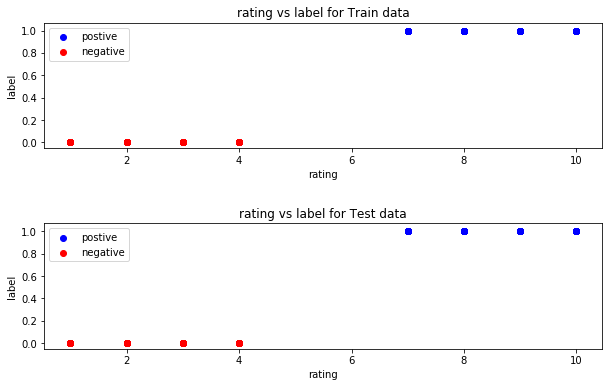

In [19]:
#Verify that all ratings <= 4 is labeled 0 and >= 7 is labeled 1
plt.subplot(2,1,1)
plt.scatter('rating', 'label', data=imdb_train[imdb_train['label'] == 1], c='b', label='postive')
plt.scatter('rating', 'label', data=imdb_train[imdb_train['label'] == 0], c='r', label='negative')
plt.title('rating vs label for Train data')
plt.xlabel('rating')
plt.ylabel('label')
plt.legend()

plt.subplot(2,1,2)
plt.scatter('rating', 'label', data=imdb_test[imdb_test['label'] == 1], c='b', label='postive')
plt.scatter('rating', 'label', data=imdb_test[imdb_test['label'] == 0], c='r',label='negative')
plt.title('rating vs label for Test data')
plt.xlabel('rating')
plt.ylabel('label')
plt.legend()

plt.subplots_adjust(hspace=0.6)
plt.show()

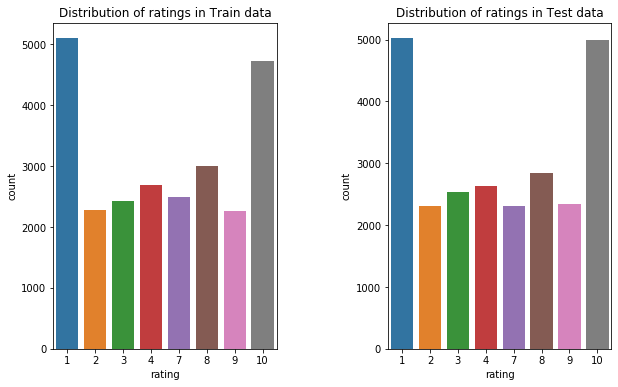

In [20]:
plt.subplot(1,2,1)
sns.countplot(x= 'rating', data = imdb_train)
plt.title('Distribution of ratings in Train data')

plt.subplot(1,2,2)
sns.countplot(x= 'rating', data = imdb_test)
plt.title('Distribution of ratings in Test data')

plt.subplots_adjust(wspace=0.5)
plt.show()

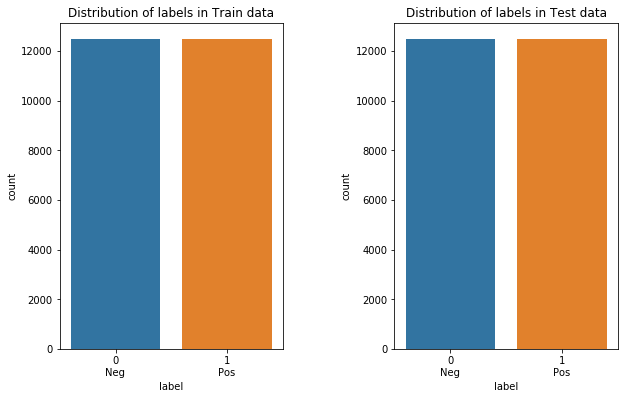

In [21]:
#Distrubution of positive and negative reviews in Train set
plt.subplot(1,2,1)
sns.countplot(x= 'label', data = imdb_train)
plt.title('Distribution of labels in Train data')
plt.xticks([0,1],["0\nNeg", "1\nPos"])

plt.subplot(1,2,2)
sns.countplot(x= 'label', data = imdb_test)
plt.title('Distribution of labels in Test data')
plt.xticks([0,1],["0\nNeg", "1\nPos"])

plt.subplots_adjust(wspace=0.5)
plt.show()

Top 20 unigrams in positive reviews:


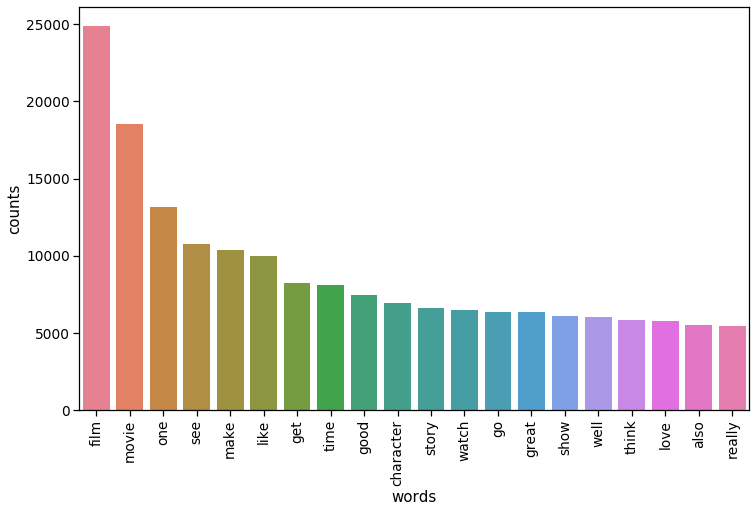

Top 20 bigrams in positive reviews:


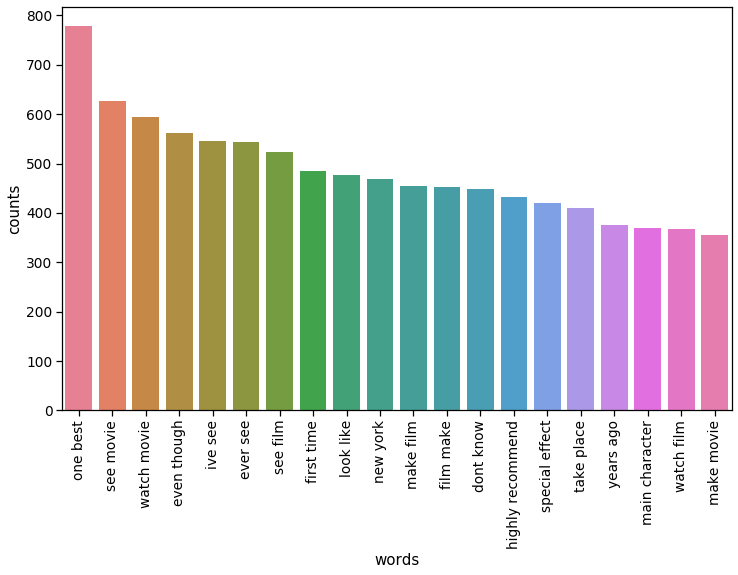

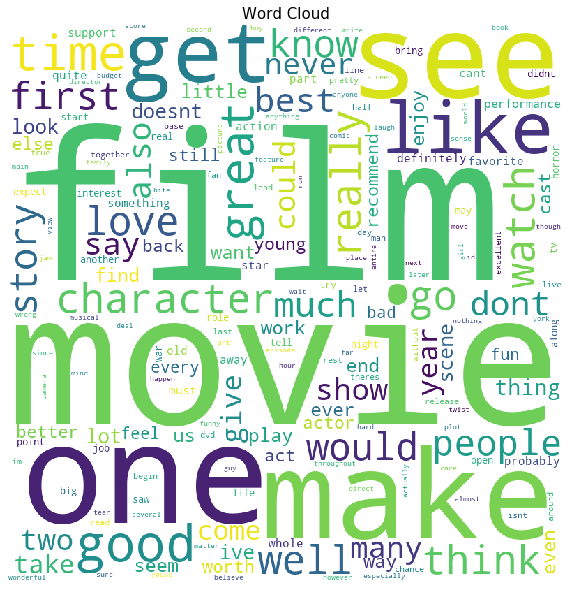

In [22]:
#separate the positive and negative reviews in train data using filters
pos = imdb_train['label'] == 1
neg = imdb_train['label'] == 0

#Display top 20 unigrams for positive reviews
print("Top 20 unigrams in positive reviews:")
count_vect = CountVectorizer(min_df=50, ngram_range=(1,1))
pos_rev_vect = count_vect.fit_transform(imdb_train[pos].review_lemma.values)
visualize_reviews(pos_rev_vect, count_vect, wordcloud_flag=0)

#Display top 20 bigrams for positive reviews
print("Top 20 bigrams in positive reviews:")
count_vect = CountVectorizer(min_df=50, ngram_range=(2,2))
pos_rev_vect = count_vect.fit_transform(imdb_train[pos].review_lemma.values)
visualize_reviews(pos_rev_vect, count_vect, wordcloud_flag=1)

Top 20 unigrams in negative reviews:


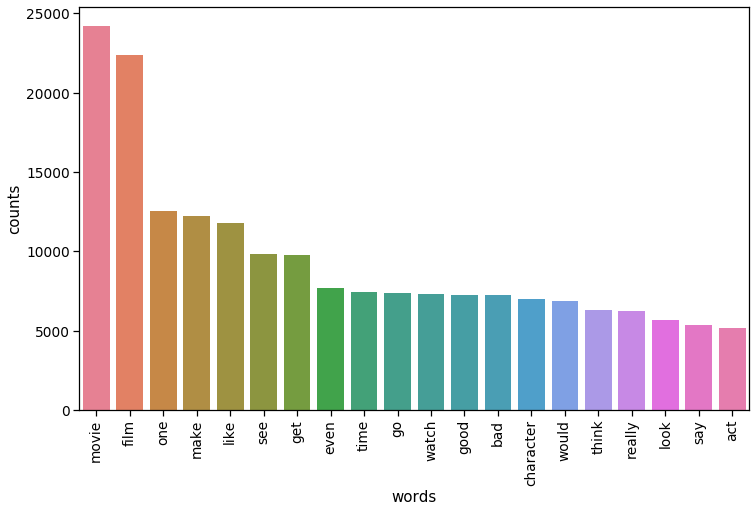

Top 20 bigrams in negative reviews:


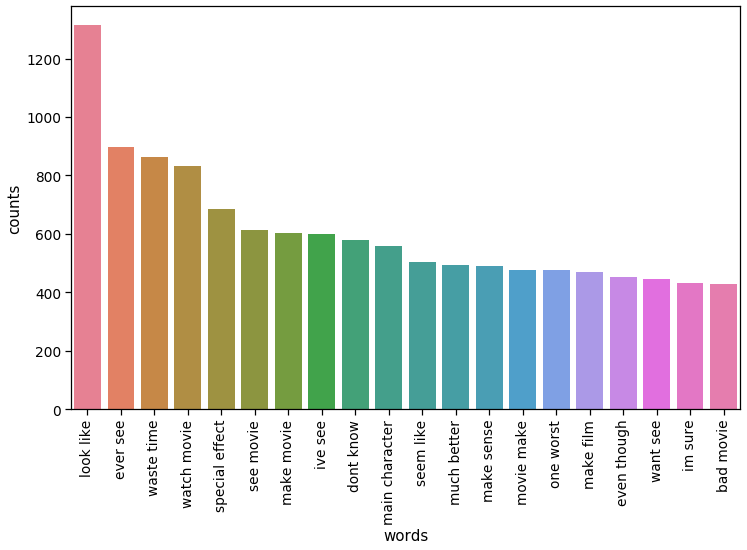

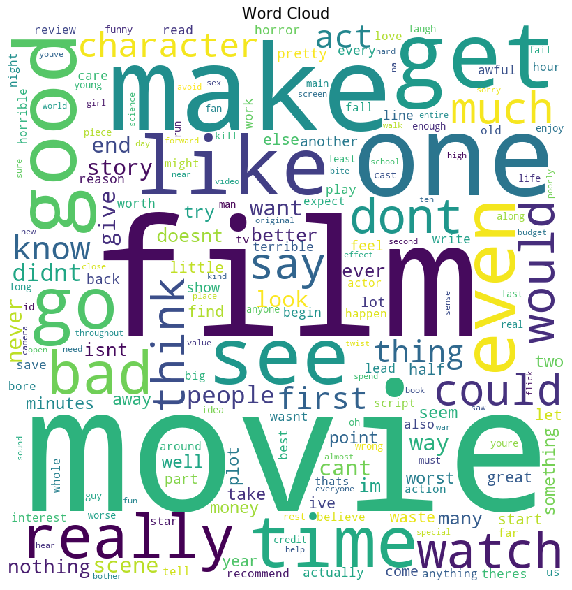

In [23]:
#Display top 20 unigrams for negative reviews
print("Top 20 unigrams in negative reviews:")
count_vect = CountVectorizer(min_df=50, ngram_range=(1,1))
pos_rev_vect = count_vect.fit_transform(imdb_train[neg].review_lemma.values)
visualize_reviews(pos_rev_vect, count_vect, wordcloud_flag=0)

#Display top 20 bigrams for negative reviews
print("Top 20 bigrams in negative reviews:")
count_vect = CountVectorizer(min_df=50, ngram_range=(2,2))
pos_rev_vect = count_vect.fit_transform(imdb_train[neg].review_lemma.values)
visualize_reviews(pos_rev_vect, count_vect, wordcloud_flag=1)

# 3. Count Vectorizer

In [24]:
#Fit CountVectorizer() and TfidfTransformer() to Train set, and transform the Test set
count_vect = CountVectorizer(min_df = 50, ngram_range=(1,2))
X_train_cv = count_vect.fit_transform(imdb_train['review_lemma'].values)
X_test_cv = count_vect.transform(imdb_test['review_lemma'].values)

tfidf_vect = TfidfTransformer()
X_train = tfidf_vect.fit_transform(X_train_cv)
X_test = tfidf_vect.transform(X_test_cv)

y_train = imdb_train['label'].values
y_test = imdb_test['label'].values

In [25]:
print("Number of features generated for our Classification model after CountVectorizer: ", X_train_cv.shape[1])

Number of features generated for our Classification model after CountVectorizer:  7957


In [26]:
print("Shape of Train dataset", X_train.shape)
print("Shape of Test dataset", X_test.shape)

Shape of Train dataset (25000, 7957)
Shape of Test dataset (25000, 7957)


In [27]:
count_vect.vocabulary_

{'title': 7154,
 'get': 2821,
 'attention': 425,
 'wonder': 7776,
 'come': 1176,
 'plot': 5344,
 'see': 6141,
 'many': 4236,
 'movies': 4649,
 'years': 7903,
 'fact': 2276,
 'really': 5682,
 'like': 3945,
 'number': 4903,
 'unusual': 7416,
 'funny': 2765,
 'scenes': 6084,
 'didnt': 1658,
 'expect': 2227,
 'perform': 5244,
 'average': 452,
 'role': 5952,
 'surprisingly': 6830,
 'able': 4,
 'watch': 7592,
 'toe': 7163,
 'wide': 7724,
 'screen': 6110,
 'begin': 569,
 'kill': 3742,
 'bill': 649,
 'luke': 4122,
 'wilson': 7743,
 'however': 3336,
 'play': 5324,
 'well': 7658,
 'idiot': 3389,
 'everyday': 2167,
 'guy': 3107,
 'meet': 4319,
 'big': 637,
 'woman': 7772,
 'could': 1350,
 'situation': 6399,
 'want': 7550,
 'light': 3939,
 'touch': 7196,
 'fun': 2756,
 'definitely': 1564,
 'adventure': 135,
 'especially': 2087,
 'cheer': 1035,
 'partner': 5173,
 'collection': 1165,
 'see many': 6171,
 'really like': 5703,
 'didnt expect': 1661,
 'play well': 5331,
 'could really': 1368,
 'really g